In [1]:
import time
import asyncio
import argparse
import pandas as pd
import numpy as np

from redis import client

In [2]:
# configuration
DATA_LOCATION = "/data"
REDIS_HOST="172.20.0.20"
REDIS_PORT="6379"

## 1. Prepare Feature Store

First, the features need to be loaded into redis so that our loan prediction model can retrieve them at inference time. To do this, we will load in our datasets with Pandas, and set all the rows of the `zipcode` and `credit` datasets as Redis hashes.

In Redis, hashes are like Python dictionaries with keys and values. One key is used to reference the entire dictionary. For the zipcode dataset this will be the `zipcode` column and for the credit dataset this will be the `dob_ssn` column.

The following functions will connect to Redis and store our feature data as described above.

In [3]:
redis_client = client.Redis(host=REDIS_HOST, port=REDIS_PORT)

def prepare_feature_store(data_path):
    credit_dataset = pd.read_parquet(f"{data_path}/credit_history.parquet")
    zipcode_dataset = pd.read_parquet(f"{data_path}/zipcode_table.parquet")

    # Drop unused features
    zipcode_dataset = zipcode_dataset.drop(columns=["city",
                                                    "state",
                                                    "location_type",
                                                    "event_timestamp",
                                                    "created_timestamp"])
    credit_dataset = credit_dataset.drop(columns=["event_timestamp", "created_timestamp"])
    load_dataframe("dob_ssn", credit_dataset)
    load_dataframe("zipcode", zipcode_dataset)
    
def load_dataframe(key_name, df):
    records = df.to_dict(orient="records")
    pipe = redis_client.pipeline()
    for record in records:
        key = record.pop(key_name)
        pipe.hset(key, mapping=record)
    pipe.execute()
    


In [4]:
%%time
# this should take about 2 minutes
prepare_feature_store(DATA_LOCATION)

CPU times: user 1min 21s, sys: 1.89 s, total: 1min 23s
Wall time: 1min 32s


Now we can check to see the feature data loaded into Redis and what it looks like.

In [5]:
!redis-cli -h $REDIS_HOST -p $REDIS_PORT info keyspace

# Keyspace
db0:keys=57477,expires=0,avg_ttl=0


In [6]:
# get a random entry from the credit features
!redis-cli -h $REDIS_HOST -p $REDIS_PORT hgetall 19660915_3573

 1) "credit_card_due"
 2) "3304"
 3) "mortgage_due"
 4) "958801"
 5) "student_loan_due"
 6) "45454"
 7) "vehicle_loan_due"
 8) "18259"
 9) "hard_pulls"
10) "0"
11) "missed_payments_2y"
12) "0"
13) "missed_payments_1y"
14) "0"
15) "missed_payments_6m"
16) "0"
17) "bankruptcies"
18) "0"


In [7]:
# get a random entry from the zipcode features.
!redis-cli -h $REDIS_HOST -p $REDIS_PORT hgetall 12542

1) "tax_returns_filed"
2) "2956"
3) "population"
4) "5193"
5) "total_wages"
6) "140664086"


## 2. Prepare Inference Workflow

The inference workflow will have 4 components to it that we will use the RedisAI Directed Acyclic Graph construct to string into a single call to Redis. 
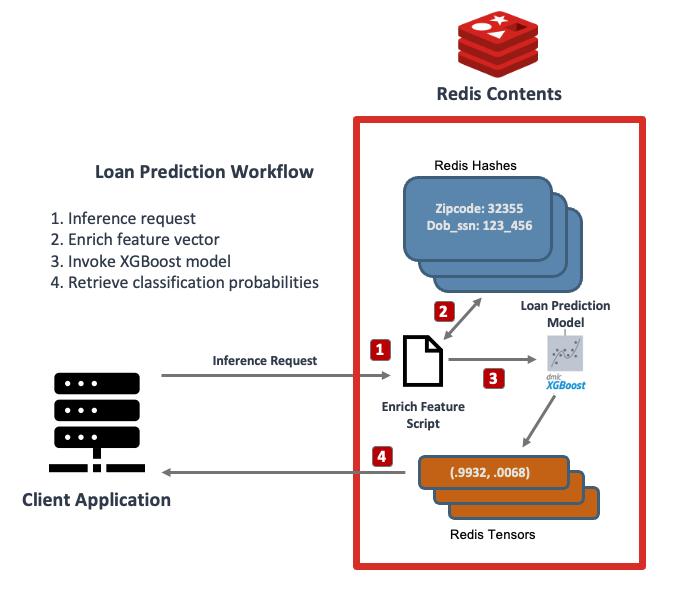


The RedisAI scripting interface uses TorchScript, JIT-traced Python, to run pre/post processing scripts needed for infernce workflows. The entire TorchScript library, with all it's available functions, can be used without needing to worry about dependencies because it's all built in.

Every script in RedisAI has `entry_points` which are functions that can be called within the script by name. All `entry_points` have the same function signature:
```python
def script(tensors: List[Tensor], keys: List[str], args: List[str]):
```
`Tensors` are the input tensors, stored in Redis, that are passed to this function directly.
`Keys` are the Redis keys that will be accessed during the execution of this function.
`args` are request time strings that can be additionally passed to a script from the client side.


For this workflow, we will use the script interface to
- Recieve the input request
- Lookup credit and zipcode features stored in Redis
- Take feature values from Redis hashes and convery to float values
- Prepare an input torch.Tensor for our model

In order to have RedisAI collect the needed features, we create a `enrich_features` script that takes in two components:
1. `args`: Request time features (age, income, employment length, etc)
2. `keys`: Lookup features (zipcode, dob_ssn)

Since our feature data is not stored as tensors, no tensors will be passed to the function.

In [8]:
%%writefile script.py
def enrich_features(tensors: List[Tensor], keys: List[str], args: List[str]):
    features = args
    credit_features = [str(x) for x in redis.asList(redis.execute("HVALS", keys[0]))]
    zipcode_features = [str(x) for x in redis.asList(redis.execute("HVALS", keys[1]))]
    features.extend(credit_features)
    features.extend(zipcode_features)
    input_tensor = torch.tensor([float(feature) for feature in features]).reshape(1,17)
    return input_tensor


Overwriting script.py


In [9]:
# Now we can load the script into Redis and call it to test it.
import redisai
rai_client = redisai.Client(host=REDIS_HOST, port=REDIS_PORT)

def load_script(script_path, rai_client):
    with open(script_path, "r") as f:
        script_bytes = f.read()

    rai_client.scriptstore("get_loan_features",
                           device="CPU",
                           script=script_bytes,
                           entry_points=["enrich_features"],
                           tag="v1")
load_script("./script.py", rai_client)

In [10]:
# check to ensure the script was loaded correctly
!redis-cli -h $REDIS_HOST -p $REDIS_PORT AI.INFO get_loan_features

 1) "key"
 2) "get_loan_features"
 3) "type"
 4) "SCRIPT"
 5) "backend"
 6) "TORCH"
 7) "device"
 8) "CPU"
 9) "tag"
10) "v1"
11) "duration"
12) (integer) 0
13) "samples"
14) (integer) -1
15) "calls"
16) (integer) 0
17) "errors"
18) (integer) 0


In [11]:
zipcode = "12542"
dob_ssn = "19510613_1349"
request_features = {
    "age": "29",
    "income": "100000",
    "yr_employment_length": "3",
    "loan_amount": "10000000",
    "loan_int_rate": "7.2"
}
output_keyname = "sample_script_out"
rai_client.scriptexecute("get_loan_features",
                         "enrich_features",
                         keys=[zipcode, dob_ssn],
                         args=list(request_features.values()),
                         outputs=[output_keyname]
                        )

'OK'

In [13]:
# get the result of the script execution which
# is the collected list of features from our
# two feature datasets (credit and zipcode)
# stored in Redis
rai_client.tensorget(output_keyname)

array([[2.9000000e+01, 1.0000000e+05, 3.0000000e+00, 1.0000000e+07,
        7.1999998e+00, 2.9560000e+03, 5.1930000e+03, 1.4066408e+08,
        3.6850000e+03, 1.5685300e+05, 1.8900000e+04, 3.9410000e+03,
        1.0000000e+00, 7.0000000e+00, 1.0000000e+00, 1.0000000e+00,
        2.0000000e+00]], dtype=float32)

## 2.1 Load Model

At this point you should have trained the model in the notebook located in this repo and saved it into the `DATA_LOCATION` directory listed above. For the XGBoost model, the RedisAI ONNX backend will be used. 



In [14]:

def load_model(model_path, rai_client):
    with open(model_path, "rb") as f:
        model_bytes = f.read()

    rai_client.modelstore("loan_model",
                          backend="ONNX",
                          device="CPU",
                          data=model_bytes,
                          tag="v1")

load_model(f"{DATA_LOCATION}/loan_model.onnx", rai_client)

In [15]:
# check to make sure the model loaded correctly
!redis-cli -h $REDIS_HOST -p $REDIS_PORT AI.INFO loan_model

 1) "key"
 2) "loan_model"
 3) "type"
 4) "MODEL"
 5) "backend"
 6) "ONNX"
 7) "device"
 8) "CPU"
 9) "tag"
10) "v1"
11) "duration"
12) (integer) 0
13) "samples"
14) (integer) 0
15) "calls"
16) (integer) 0
17) "errors"
18) (integer) 0


## 2.2 Create and Call the Inference DAG

After the model is loaded, we contruct a directed acyclic graph (DAG) of commands to run such that each inference call is only one client invocation. This is similar to the `pipeline` feature of normal redis clients.

The DAG for the inference workflow is shown below
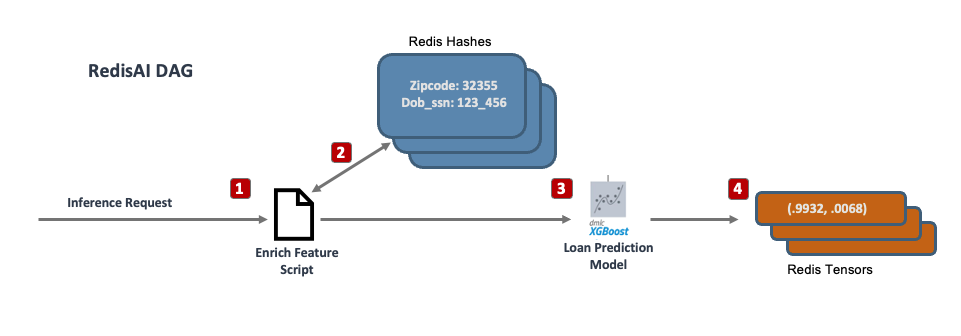


In [16]:
script_key = 'get_loan_features'
model_key = 'loan_model'

def get_loan_prediction(dob_ssn: str, zipcode: str, age: int, income: int, emp_length: int, loan_amount: int, int_rate: float):
    keys = [dob_ssn, zipcode]
    input_args = [str(x) for x in [age, income, emp_length, loan_amount, int_rate]]
    out_tag = hash(dob_ssn)
    
    dag = rai_client.dag(persist=[f"{out_tag}_class", f"{out_tag}_prob"])
    dag.scriptexecute(script_key, 'enrich_features', keys=keys, args=input_args, outputs=['model_input'])
    dag.modelexecute(model_key, inputs=['model_input'], outputs=[f'{out_tag}_class', f"{out_tag}_prob"])
    dag.execute()
    
    score = rai_client.tensorget(f'{out_tag}_class')
    probabilities = rai_client.tensorget(f"{out_tag}_prob")
    loan_decision = "Approved" if score[0] == 1 else "Denied"
    return loan_decision, probabilities


In [19]:
%%time
get_loan_prediction("19950809_7983", "24265", 25, 10000, 5, 1000, 6.3)

CPU times: user 1.96 ms, sys: 0 ns, total: 1.96 ms
Wall time: 2.46 ms


('Denied', array([[0.57323503, 0.42676497]], dtype=float32))